<a href="https://colab.research.google.com/github/QuqqU/Algorithm-DataStructure/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch로 MNIST 학습하기
기본 모듈 다운로드

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

구글 클라우드 마운트

In [2]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'
PROJECT_PATH = join(ROOT, 'MyDrive/datasets/mnist')

drive.mount(ROOT)

Mounted at /content/drive


환경 변수 설정

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)
BATCH_SIZE = 32
EPOCHS = 10

Using PyTorch version: 1.8.0+cu101  Device: cpu


MNIST 구글 클라우드에 다운로드

* 곧바로 다운로드를 하려면 Cloudflare때문에 403 fobidden이 생긴다. 아래의 자료를 참고하자.
* 1) https://stackoverflow.com/questions/60548000/getting-http-error-403-forbidden-error-when-download-mnist-dataset
* 2) https://github.com/pytorch/vision/issues/1938

In [ ]:
import urllib
from six.moves import urllib    
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
def set_header_for(url, filename):
    opener = urllib.request.URLopener()
    opener.addheader('User-Agent', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36')
    opener.retrieve(
    url, f'{PROJECT_PATH}/{filename}')
set_header_for('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'train-images-idx3-ubyte.gz')
set_header_for('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte.gz')
set_header_for('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz')
set_header_for('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

train_dataset = datasets.MNIST(root = PROJECT_PATH,
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = PROJECT_PATH,
                              train = False,
                              download = True,
                              transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

데이터 확인

x_train:  torch.Size([32, 1, 28, 28]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor
[4, 8, 1, 3, 3, 8, 7, 5, 6, 0, 4, 0, 3, 2, 2, 6, 2, 5, 4, 5, 2, 2, 2, 7, 0, 2, 3, 3, 2, 0, 1, 9]


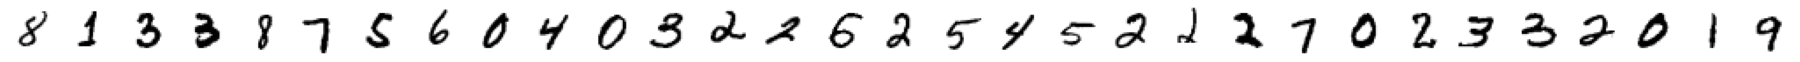

In [5]:
for(x_train, y_train) in train_loader:
    print('x_train: ', x_train.size(), 'type: ', x_train.type())
    print('y_train: ', y_train.size(), 'type: ', y_train.type())
    break
    
# batch size = 32

## answer
print([y.item() for y in y_train])

## hand-write data
pltsize = 1
plt.figure(figsize=(32 * pltsize, pltsize))
for i in range(1, 32):
    plt.subplot(1, 31, i)
    plt.axis('off')
    plt.imshow(x_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")

# MLP 구축하기
입력층 -> 시그모이드
-> 히든 -> 시그모이드
-> 출력층 -> 소프트맥스

In [96]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

모델 확인하기

In [97]:
model1 = MLP().to(DEVICE)
model2 = MLP().to(DEVICE)
model3 = MLP().to(DEVICE)
model4 = MLP().to(DEVICE)
print(model1)

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


옵티마이저와 손실함수
1. 옵티마이저 SGD(확률적 경사 하강법) : 무난하게 많이 사용하는 걸 사용했다.
    learning rate = 0.01
    momemtum = 0
2. 손실함수 : CrossEntorpyLoss



In [98]:
optim1 = torch.optim.SGD(model1.parameters(), lr = 0.05)
optim2 = torch.optim.SGD(model2.parameters(), lr = 0.05)
optim3 = torch.optim.SGD(model3.parameters(), lr = 0.05)
optim4 = torch.optim.SGD(model4.parameters(), lr = 0.05)
crite = nn.CrossEntropyLoss()

학습시키기

In [99]:
def train(model, train_loader, optim, qtr=4):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        if(batch_idx > len(train_loader.dataset) * qtr // 4): break
        x = image.to(DEVICE)
        y = label.to(DEVICE)
        optim.zero_grad()
        y_hat = model(x)
        loss = crite(y_hat, y)
        loss.backward()
        optim.step()


테스트하기

In [100]:
def test(model, test_loader):
    model.eval()
    loss = 0
    ans = 0

    with torch.no_grad():
        for image, label in test_loader:
            x = image.to(DEVICE)
            y = label.to(DEVICE)
            y_hat = model(x)
            loss += crite(y_hat, y).item()
            prediction = y_hat.max(1, keepdim=True)[1]
            ans += prediction.eq(y.view_as(prediction)).sum().item()

    loss /= len(test_loader.dataset)
    accuracy = 100. * ans / len(test_loader.dataset)
    return loss, accuracy

# 모델 학습 후 테스트
## total_loss & accuracy
1. 전체 데이터셋 1/4 사용 학습


In [ ]:
for epoch in range(3):
    train(model1, train_loader, optim1, 1)
    l1, a1 = test(model1, test_loader)
    print(l1, a1)

2. 전체 데이터셋 2/4 사용 학습

In [ ]:
for epoch in range(5):
    train(model2, train_loader, optim2, 1)
    l2, a2 = test(model2, test_loader)
    print(l2, a2)

3. 전체 데이터셋 3/4 사용 학습

In [ ]:
for epoch in range(5):
    train(model3, train_loader, optim3, 1)
    l3, a3 = test(model3, test_loader)
    print(l3, a3)

4. 전체 데이터셋 4/4 사용 학습

In [ ]:
for epoch in range(5):
    train(model4, train_loader, optim4, 1)
    l4, a4 = test(model4, test_loader)
    print(l4, a4)

# 학습결과

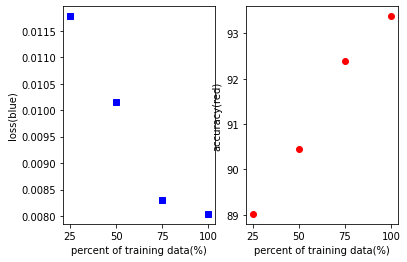

In [117]:
plt.subplot(1, 2, 1)
plt.xlabel('percent of training data(%)')
plt.xticks([25, 50, 75, 100])
plt.ylabel('loss(blue)')
plt.plot([25, 50, 75, 100], [l1, l2, l3, l4], 'bs')
plt.subplot(1, 2, 2)
plt.xlabel('percent of training data(%)')
plt.xticks([25, 50, 75, 100])
plt.ylabel('accuracy(red)')
plt.plot([25, 50, 75, 100], [a1, a2, a3, a4], 'ro')
plt.show()